In [2]:
import matplotlib.pyplot as plt
import numpy as np

from physics.sound_propagation import *

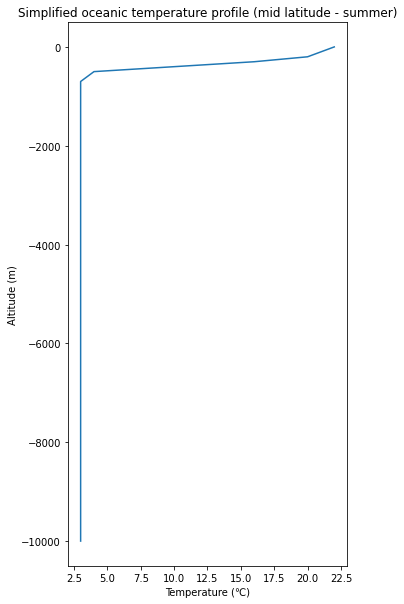

In [3]:
# from https://archive.bigelow.org/shipmates/octemp.html
temp_profile = np.array([
    [0, 22],
    [100, 21],
    [200, 20],
    [300, 16],
    [400, 10],
    [500, 4],
    [600, 3.5],
    [700, 3],
    [800, 3],
    [900, 3],
    [1000, 3],
    [1100, 3],
    [1200, 3],
    [1300, 3],
    [1400, 3],
    [1500, 3],
    [10000, 3]
])

plt.figure(figsize=(5, 10))
plt.plot(temp_profile[:, 1], -1 * temp_profile[:, 0])
plt.xlabel('Temperature (℃)')
plt.ylabel('Altitude (m)')
plt.title('Simplified oceanic temperature profile (mid latitude - summer)')
plt.show()


temperature = temp_profile.T
temperature[0] *= -1

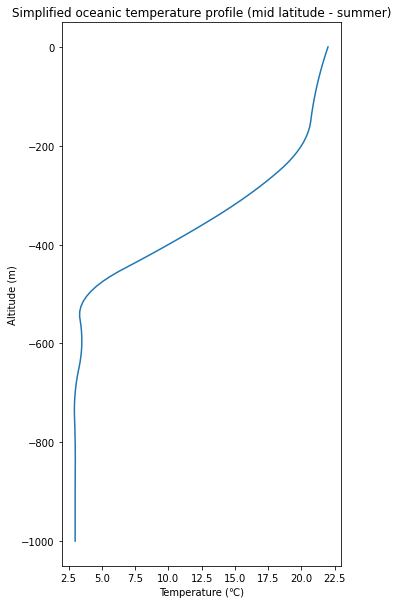

In [4]:
def calc_T_old (z):
    z_ref = temperature[0]
    n = z_ref.shape[0]

    # Calculate closest depth reference  sample
    z_ref_tiled = np.tile(z_ref, (z.shape[0], 1))
    z_tiled = np.tile(z, (n, 1)).T
    dist = np.abs(z_tiled - z_ref_tiled)
    ids = np.argmin(dist, axis=1)

    T = temperature[1][ids]
    return T


def calc_T_np (z):
    return np.interp(z, temperature[0][::-1], temperature[1][::-1])


from scipy import interpolate
calc_T = interpolate.interp1d(temperature[0][::-1], temperature[1][::-1], kind='quadratic')

z = np.linspace(-1000, 0, 100)[::-1]
plt.figure(figsize=(5, 10))
plt.plot(calc_T(z), z)
plt.xlabel('Temperature (℃)')
plt.ylabel('Altitude (m)')
plt.title('Simplified oceanic temperature profile (mid latitude - summer)')
plt.show()

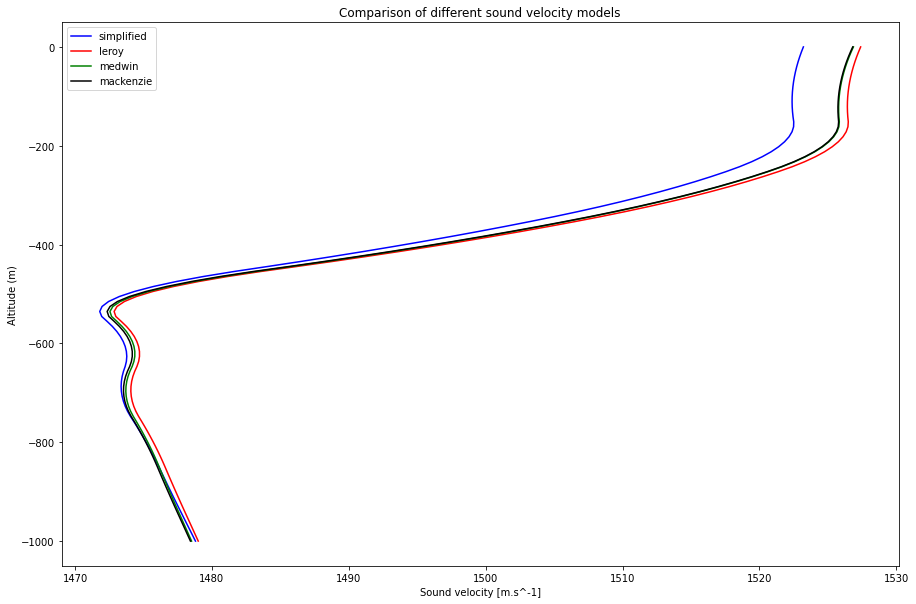

In [5]:
S = 35
z = np.linspace(-1000, 0, 100)#[::-1]
T = calc_T(z)

c_simplified = sound_velocity_simplified(S, T, z)
c_leroy      = sound_velocity_leroy     (S, T, z)
c_medwin     = sound_velocity_medwin    (S, T, z)
c_mackenzie  = sound_velocity_mackenzie (S, T, z)


plt.figure(figsize=(15, 10))

plt.plot(c_simplified, z, c='blue', label='simplified')
plt.plot(c_leroy, z, c='red', label='leroy')
plt.plot(c_medwin, z, c='green', label='medwin')
plt.plot(c_mackenzie, z, c='black', label='mackenzie')

plt.legend()
plt.title('Comparison of different sound velocity models')
plt.xlabel('Sound velocity [m.s^-1]')
plt.ylabel('Altitude (m)')
plt.show()

In [6]:
def clamp(x, low, high):
    return min(max(low, x), high)

In [ ]:
def calc_c (z):
    return sound_velocity_medwin(35, calc_T(z), z)


LIMIT_TOP    = 0
LIMIT_BOTTOM = -1000

def sound_curve(time: np.ndarray, step_size, x0, z0, theta_0, color='black'):
    """
    :param theta_0: Initial angle (in radians)
    """

    X, Z = [x0, ], [z0, ]

    c = calc_c(z0)
    theta = theta_0
    sigma = np.sin(theta) / c
    
    for i, t in enumerate(time):
        
        # Retrieve previous position
        x, z = X[i], Z[i]

        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        tan_theta = sin_theta / cos_theta

        # Move
        dx = sin_theta * step_size #* c * dt
        dz = cos_theta * step_size #* c * dt
        x_new = x + dx
        z_new = z + dz
        
        theta_add = 0

        # Check limit
        if z_new > LIMIT_TOP:
            x_new = x - tan_theta * (LIMIT_TOP - z)  # intersection with LIMIT_TOP
            z_new = LIMIT_TOP
            theta_add = np.pi / 2

        X.append(x_new)
        Z.append(z_new)

        # Calculate next parameters
        c_old = c
        c     = calc_c(Z[i+1])

        theta_old = theta
        print(c / c_old)
        sigma = c / c_old * np.sin(theta_old)
        theta = np.arcsin(c * sigma) + theta_add

        print(theta)

        # Calculate new angle
        # try: c = calc_c(Z[i+1])
        # except: return np.array(X), np.array(Z)

        
    
    return np.array(X), np.array(Z)






# Initial conditions
x0 = 0
z0 = -500

theta_0 = 1 #3.14 / 2
def tan0 (x): return (x - x0) / np.tan(theta_0) + z0


plt.figure(figsize=(15, 10))
plt.plot([x0, x0 + 1e2], [z0, tan0(x0 + 1e2)], c='blue', label=f'{theta_0} rad')

###############################
time = np.arange(0, 500, 1)
print(time.shape)
X, Z = sound_curve(time, 10, x0, z0, theta_0=theta_0, color='blue')
# print(X, Z)

plt.plot(X, Z)
plt.scatter(X, Z)
plt.legend()
plt.show()










In [13]:
def calc_c (z):
    return sound_velocity_medwin(35, calc_T(z), z)

z = np.linspace(-10000, 0, 10000)
c = calc_c(z)
dz_c = np.gradient(c)
calc_dz_c = interpolate.interp1d(z, dz_c, kind='quadratic')

# z_fine = np.linspace(-1000, 0, 10000)
# plt.figure(figsize=(15, 10))
# plt.plot(calc_dz_c(z_fine), z_fine)
# plt.show()

# plt.figure(figsize=(15, 10))
# plt.plot(c, z)
# plt.show()

In [86]:
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.keys())

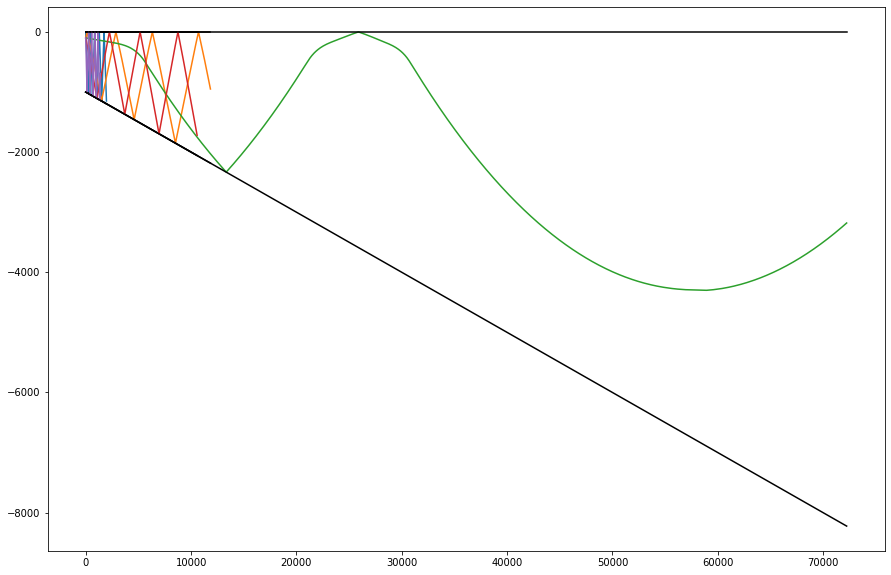

In [85]:
from scipy.optimize import fsolve

def sound_curve (n_steps, step_z, x0, z0, theta_0):
    # Initialise differential solver parameters
    c0      = calc_c(0)
    mult   = -1 * np.power(c0 / np.sin(theta_0), 2)  # differential equation multiplier
    X = np.array([x0, ])
    Z = np.array([z0, ])
    dx_z   = 1 / np.tan(theta_0)
    dxdx_z = 0  # no initial curvature


    for i in range(n_steps):
        x = X[i]
        z = Z[i]

        # Calculate point
        dz = np.sign(dx_z) * step_z
        dx = dz / dx_z

        x_new = x + dx
        z_new = z + dz
        if z_new > LIMIT_TOP:
            z_new = LIMIT_TOP
            x_new = x + (LIMIT_TOP - z) / dx_z
            dx_z *= -1

        elif z_new < LIMIT_BOTTOM(x_new):
            def g(x1): return LIMIT_BOTTOM(x) - dx_z * (x1 - x) - z
            x_new = float(fsolve(g, x0=x))
            z_new = LIMIT_BOTTOM(x_new)
            dx_z *= -1  # assuming horizontal reflection

        X = np.concatenate((X, np.array([x_new, ])), axis=0)
        Z = np.concatenate((Z, np.array([z_new, ])), axis=0)

        # Calculate new point's properties
        c = calc_c(z)
        g = calc_dz_c(z)

        dxdx_z = mult * g / np.power(c, 3)
        dx_z  += dxdx_z * dx

    return np.array(X), np.array(Z)



LIMIT_TOP = 0  # in m
def LIMIT_BOTTOM (x):
    return -0.1 * x - 1000
    return np.ones_like(x) * -1000

n_steps = 1000
step_z = 10

# Initial conditions
x0      = 0
z0      = -100
theta_0 = 3.14/2 -0.1  #in radians


plt.figure(figsize=(15, 10))
for theta_0 in np.linspace(0.2, 3, 5):
    X, Z = sound_curve(n_steps, step_z, x0, z0, theta_0)
    plt.plot(X, Z)
    plt.plot((X[0], X[-1]), (0, 0), c='black')
    plt.plot(X, LIMIT_BOTTOM(X), c='black')

plt.show()

In [4]:
def GROUND_HEIGHT_2D (x: np.ndarray):
    """
    Get ground height in meters
    :param x: position (in meters)
    :return: ground height (in meters)
    """
    return -100. * np.ones(shape=x.shape[0])

[6.38233599]
[20.94867794]
[36.63624684]
[54.49828781]
[76.17212457]
[104.59713328]
[145.93051898]
[216.03302679]
[372.86802316]
[1137.63059425]


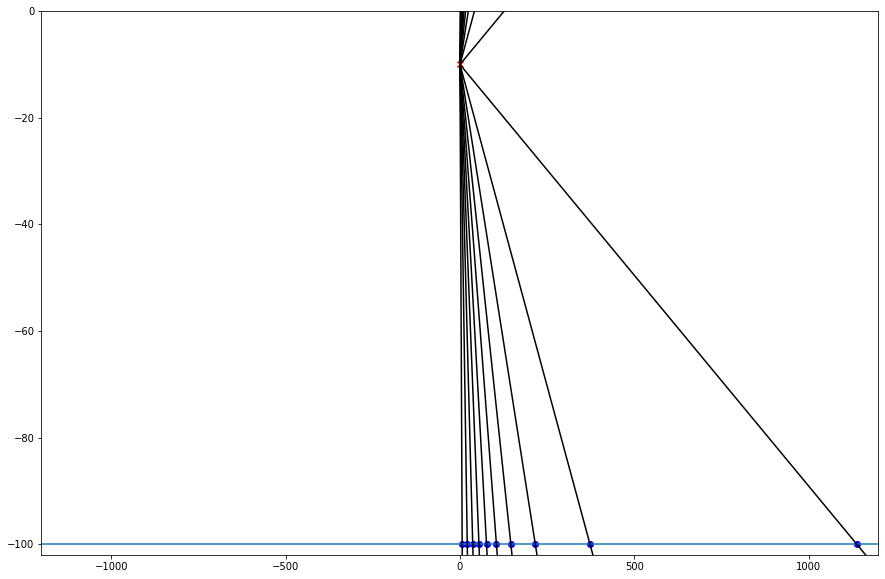

In [20]:
from scipy.optimize import fsolve
from math import pi as PI


plt.figure(figsize=(15, 10))
plt.xlim((-1200, 1200))
plt.ylim((-102, 0))


EMITTER_POS = (0, -10)  # in meters
plt.scatter(*EMITTER_POS, c='red', marker='x')


dist = np.linspace(-1200, 1200, 200)
plt.plot(dist, GROUND_HEIGHT_2D(dist))

angles = np.linspace (-1.5, 1.5, 20)
for angle in angles:
    

    def angle_func (x):
        a = np.tan(angle)
        return a * (x - EMITTER_POS[0]) + EMITTER_POS[1]  # a(x-xE) + yE

    samples = np.linspace(0, 2000, 100)
    plt.plot(samples, angle_func(samples), c='black')
    
    def diff_func (x):
        return np.power(angle_func(x) - GROUND_HEIGHT_2D(x), 2)
    
    x_intersect = fsolve(diff_func, x0=0)
    if x_intersect <= 0: continue
    

    print(x_intersect)
    plt.scatter(x_intersect, GROUND_HEIGHT_2D(x_intersect), c='blue')

plt.show()





